In [2]:
import numpy as np
import keras
import sys
from keras.models import Model
from keras.utils import plot_model
from keras.models import load_model
from PIL import Image
import matplotlib.pyplot as plt
from random import randint
import imageio
import argparse
from skimage.util.shape import view_as_blocks

from Crypto.Cipher import AES
from Crypto import Random
import os, random 
from Crypto.Cipher import AES 
from Crypto.Hash import SHA256 
 

# Encryption

## Autoencoder-Decoder

In [4]:
model_hide=load_model('models/hide.h5',compile=False)

In [5]:
model_hide.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
secret (InputLayer)             (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
prep_conv3x3_1 (Conv2D)         (None, 224, 224, 50) 1400        secret[0][0]                     
__________________________________________________________________________________________________
prep_conv4x4_1 (Conv2D)         (None, 224, 224, 50) 2450        secret[0][0]                     
__________________________________________________________________________________________________
prep_conv5x5_1 (Conv2D)         (None, 224, 224, 50) 3800        secret[0][0]                     
__________________________________________________________________________________________________
prep_conv3

In [6]:
# Normalize inputs
def normalize_batch(imgs):
    '''Performs channel-wise z-score normalization'''

    return (imgs -  np.array([0.485, 0.456, 0.406])) /np.array([0.229, 0.224, 0.225])

# Denormalize outputs
def denormalize_batch(imgs,should_clip=True):
    imgs= (imgs * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
    
    if should_clip:
        imgs= np.clip(imgs,0,1)
    return imgs

# Custom block shuffling
def shuffle(img, inverse = False):
    
  
  # Configure block size, rows and columns
    blk_size=56
    rows=np.uint8(img.shape[0]/blk_size)
    cols=np.uint8(img.shape[1]/blk_size)

  # Create a block view on image
    img_blks=view_as_blocks(img,block_shape=(blk_size,blk_size,3)).squeeze()
    img_shuff=np.zeros((img.shape[0],img.shape[1],3),dtype=np.uint8)

  # Secret key maps
    map={0:2, 1:0, 2:3, 3:1}
    inv_map = {v: k for k, v in map.items()}

  # Perform block shuffling
    for i in range(0,rows):
        for j in range(0,cols):
            x,y = i*blk_size, j*blk_size
            if(inverse):
                  img_shuff[x:x+blk_size, y:y+blk_size] = img_blks[inv_map[i],inv_map[j]]
            else:
                  img_shuff[x:x+blk_size, y:y+blk_size] = img_blks[map[i],map[j]]

    return img_shuff


In [7]:
# Normalize input images [float: 0-1]
import cv2
x = cv2.imread('test/secret1.png')
x = cv2.resize(x,(224,224))
x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)

y = cv2.imread('test/mask.png')
y = cv2.resize(y,(224,224))
y = cv2.cvtColor(y, cv2.COLOR_BGR2RGB)

secretin = np.array(x).reshape(1,224,224,3)/255.0
coverin = np.array(y).reshape(1,224,224,3)/255.0
#secretin[0]=shuffle(secretin[0], inverse = False)

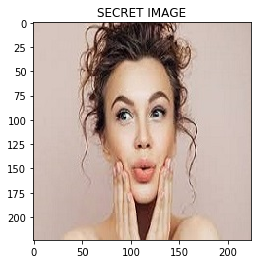

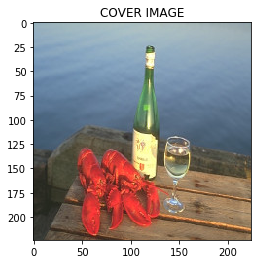

In [27]:
plt.imshow(x)
plt.title("SECRET IMAGE")
plt.show()
plt.title("COVER IMAGE")
plt.imshow(y)

In [42]:
from datetime import datetime

# datetime object containing current date and time
now = datetime.now()
 
print("now =", now)

coverout=model_hide.predict([normalize_batch(secretin),normalize_batch(coverin)])

# datetime object containing current date and time
now = datetime.now()
 
print("now =", now)


now = 2021-01-11 12:07:16.546782
now = 2021-01-11 12:07:17.368211


In [44]:
coverout = denormalize_batch(coverout)
coverout=np.squeeze(coverout)*255.0
coverout=np.uint8(coverout)

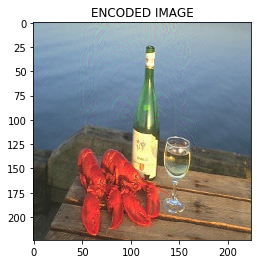

In [45]:
plt.imshow(coverout)
plt.title("ENCODED IMAGE")
plt.show()

In [46]:
imageio.imsave('test/container1.png',coverout)

## AES

In [13]:
key = Random.new().read(AES.block_size)
iv = Random.new().read(AES.block_size)

In [14]:
def encrypt(key, filename): 
    chunk_size = 64*1024 
    output_file = filename +".enc" 
    file_size = str(os.path.getsize(filename)).zfill(16)  
    IV = os.urandom(16)
    encryptor = AES.new(key, AES.MODE_CBC, IV) 
    with open(filename, 'rb') as inputfile: 
        with open(output_file, 'wb') as outf: 
            outf.write(bytes(file_size, 'utf-8'))
            outf.write(IV) 
            while True: 
                chunk = inputfile.read(chunk_size) 
                if len(chunk) == 0: 
                    break 
                elif len(chunk) % 16 != 0: 
                    chunk += (' '*(16 - len(chunk)%16)).encode("utf-8") 
                outf.write(encryptor.encrypt(chunk)) 
 
def decrypt(key, filename): 
        chunk_size = 64*1024 
        output_file = filename[:-8] +"AES_op.png" 
        with open(filename, 'rb') as inf: 
            filesize = int(inf.read(16)) 
            IV = inf.read(16) 
            decryptor = AES.new(key, AES.MODE_CBC, IV) 
            with open(output_file, 'wb') as outf: 
                while True: 
                    chunk = inf.read(chunk_size) 
                    if len(chunk)==0: 
                        break 
                    outf.write(decryptor.decrypt(chunk)) 
                outf.truncate(filesize) 
 
def getKey(password):
    hasher = SHA256.new(password.encode()) 
    return hasher.digest() 
 
def main(): 
    choice = input("Select One of the following\n> 1. Encrypt \n> 2. Decrypt\n>>> ") 
    if choice == "1": 
        filename = input("Enter the name of file to be encrypted >> ") 
        password = input("Enter the password")
        now = datetime.now()
        print("now =", now)
        encrypt(getKey(password), filename) 
        now = datetime.now()
        print("now =", now)
        print("Done!\n%s ==> %s"%(filename, filename+".enc")) 
    elif choice == "2": 
        filename = input("File to be decrypted > ") 
        password = input("Password: ") 
        decrypt(getKey(password), filename) 
        print ("Done\n%s ==> %s"%(filename, filename[:-4]))
    else: 
        print("No option Selected") 

In [48]:
main()

Select One of the following
> 1. Encrypt 
> 2. Decrypt
>>> 2
File to be decrypted > test/container1.png.enc
Password: 3214
Done
test/container1.png.enc ==> test/container1.png


# Decryption

In [16]:
model_reveal=load_model('models/reveal.h5',compile=False)

In [17]:
model_reveal.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
revl_conv3x3_1 (Conv2D)         (None, 224, 224, 50) 1400        input_1[0][0]                    
__________________________________________________________________________________________________
revl_conv4x4_1 (Conv2D)         (None, 224, 224, 50) 2450        input_1[0][0]                    
__________________________________________________________________________________________________
revl_conv5x5_1 (Conv2D)         (None, 224, 224, 50) 3800        input_1[0][0]                    
__________________________________________________________________________________________________
revl_conv3

In [49]:
# Normalize input images [float: 0-1]
stego_image = np.array(Image.open(r'test/container1AES_op.png').convert('RGB')).reshape(1,224,224,3)/255.0
# datetime object containing current date and time

now = datetime.now()
 
print("now =", now)

# Predict the output       
secretout=model_reveal.predict([normalize_batch(stego_image)])

# datetime object containing current date and time
now = datetime.now()
 
print("now =", now)

now = 2021-01-11 12:09:06.976231
now = 2021-01-11 12:09:07.329565


In [50]:
# Postprocess the output
secretout = denormalize_batch(secretout)
secretout=np.squeeze(secretout)*255.0
secretout=np.uint8(secretout)
#secretout=shuffle(secretout, inverse = True)

(224, 224, 3)

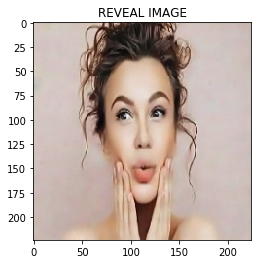

In [51]:
plt.imshow(secretout)
plt.title("REVEAL IMAGE")
secretout.shape

In [21]:
imageio.imsave("test/decoder_out.png",secretout)

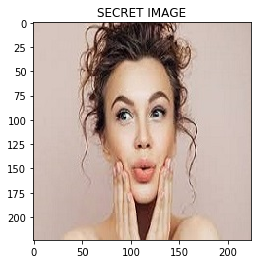

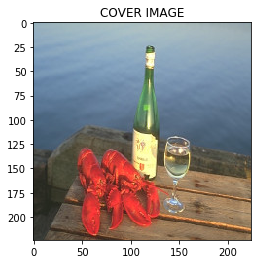

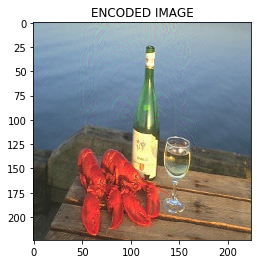

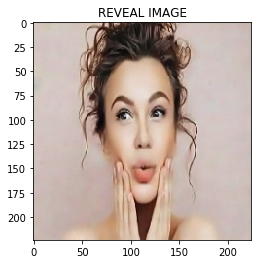

In [22]:
plt.imshow(x)
plt.title("SECRET IMAGE")
plt.show()

plt.imshow(y)
plt.title("COVER IMAGE") 
plt.show()

plt.imshow(coverout)
plt.title("ENCODED IMAGE")
plt.show()

plt.imshow(secretout)
plt.title("REVEAL IMAGE") 
plt.show()

# Noise

In [52]:
noise_img = np.zeros(coverout.shape,np.uint8)
prob=0.01
thres = 1 - prob 
for i in range(coverout.shape[0]):
    for j in range(coverout.shape[1]):
        rdn = random.random()
        if rdn < prob:
            noise_img[i][j] = 0
        elif rdn > thres:
            noise_img[i][j] = 255
        else:
            noise_img[i][j] = coverout[i][j]
imageio.imsave('test/noise.png',noise_img)

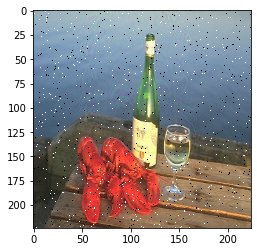

In [53]:
plt.imshow(noise_img)

In [54]:
# Normalize input images [float: 0-1]
stego_image = np.array(Image.open(r'test/noise.png').convert('RGB')).reshape(1,224,224,3)/255.0
# datetime object containing current date and time

now = datetime.now()
 
print("now =", now)

# Predict the output       
noiseout=model_reveal.predict([normalize_batch(stego_image)])

# datetime object containing current date and time
now = datetime.now()
 
print("now =", now)
noiseout = denormalize_batch(noiseout)
noiseout=np.squeeze(noiseout)*255.0
noiseout=np.uint8(noiseout)

now = 2021-01-11 12:09:37.448200
now = 2021-01-11 12:09:37.803047


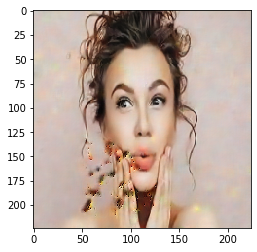

In [55]:
plt.imshow(noiseout)

In [118]:
from skimage.util import random_noise
  
# Add salt-and-pepper noise to the image.
noise_img = random_noise(coverout, mode='s&p',amount=0.01)
 
# The above function returns a floating-point image
# on the range [0, 1], thus we changed it to 'uint8'
# and from [0,255]
noise_img = np.array(255*noise_img, dtype = 'uint8')
imageio.imsave('test/noise.png',noise_img)